# Zadanie 3 — Model surogatowy ODE i aproksymacja NN
Cel:
1) Zredukować model PDE do modelu ODE (tylko czas, bez przestrzeni).  
2) Ręcznie dobrać / skalibrować parametry ODE, porównać trajektorie TB(t) z PDE.  
3) Na danych z modelu (PDE jako „prawda” na TB(t)) nauczyć prostą sieć neuronową i porównać: PDE vs ODE vs NN.  
4) Zapisać wykresy do plików PNG w katalogu głównym projektu.
Konwencje: TB(t) = ∫(S+R) dx; w ODE traktujemy TB≈S̄+R̄ (obszar znormalizowany do 1).

In [20]:
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# SciPy do integracji ODE i optymalizacji (zwykle dostępny)
try:
    from scipy.integrate import solve_ivp
    from scipy.optimize import least_squares
    SCIPY_AVAILABLE = True
except Exception as e:
    SCIPY_AVAILABLE = False
    print("Uwaga: SciPy niedostępny:", e)

def savefig_root(fname, dpi=160):
    plt.savefig(fname, dpi=dpi, bbox_inches="tight")
    print(f"[Zapisano wykres] {fname}")

In [21]:
import pandas as pd

# Spróbujemy najpierw plik z komórki 15 (porównanie solverów dla tego samego dt)
possible_csv = [
    "compare_solvers_same_dt.csv",
    "out/compare_solvers_same_dt.csv",
    "out/explicit_Nx96_Ny96_traj.csv",  # awaryjnie
    "out/semi_implicit_Nx96_Ny96_traj.csv"
]

ref = None
for path in possible_csv:
    if Path(path).exists():
        ref = pd.read_csv(path)
        src = path
        break

if ref is None:
    raise FileNotFoundError("Nie znaleziono pliku z referencją PDE. Upewnij się, że uruchomiono wcześniej komórkę 15 lub wskaż właściwy CSV.")

print(f"[OK] Wczytano referencję PDE z: {src}")

# Normalizacja do formatu: kolumny t, TB
if "TB_explicit" in ref.columns and "TB_semi_implicit" in ref.columns:
    # wybierz jedną kolumnę jako referencję (obie są prawie identyczne)
    ref_pde = pd.DataFrame({"t": ref["t"].values, "TB": ref["TB_explicit"].values})
elif {"t","tumor_burden"} <= set(ref.columns):
    ref_pde = pd.DataFrame({"t": ref["t"].values, "TB": ref["tumor_burden"].values})
else:
    raise ValueError("Nieznany format CSV. Spodziewano się kolumn (t, TB_*) lub (t, tumor_burden).")

# Podgląd
ref_pde.head()

[OK] Wczytano referencję PDE z: out/compare_solvers_same_dt.csv


,t,TB
0,0.0,0.046489
1,0.1,0.044402
2,0.2,0.041901
3,0.3,0.039633
4,0.4,0.037572


In [22]:
from dataclasses import dataclass

@dataclass
class ODEParams:
    # wzrost logistyczny
    rho_S: float = 0.04
    rho_R: float = 0.03
    K: float = 1.0

    # cytotoksyczność
    alpha_S: float = 0.8
    alpha_R: float = 0.12

    # immunologia
    sigma: float = 0.05
    delta: float = 0.1
    gamma_S: float = 0.02
    gamma_R: float = 0.02

    # farmakokinetyka leku
    lam: float = 0.2
    beta: float = 0.0  # na start 0, jak w prostym wariancie PDE

    # indukcja oporności
    mu_max: float = 0.05
    C50: float = 0.2
    m_hill: int = 3

    # dawkowanie
    dose_type: str = "bolus_periodic"  # 'bolus_periodic' | 'infusion_const' | 'none'
    dose_A: float = 1.0
    dose_period: float = 5.0
    infusion_rate: float = 0.0

def mu_of_C(C, mu_max, C50, m):
    # stabilna postać
    Cn = max(C, 0.0)
    ratio = (Cn / (C50 + 1e-12))**m
    return mu_max * (ratio / (1.0 + ratio))

def dosing_term_exact(t, dt, period, A):
    # średnie I_in w okienku [t,t+dt] dla prostokątnego impulsu o długości 1% okresu
    tau = 0.01 * period
    t0 = (t // period) * period
    start, end = t0, t0 + tau
    overlap = max(0.0, min(t+dt, end) - max(t, start))
    return (A / tau) * (overlap / max(dt, 1e-12))

def ode_rhs(t, y, p: ODEParams, dt_for_dose=None):
    # y = [S, R, I, C]
    S, R, I, C = y
    N = S + R

    # wzrost logistyczny
    dS = p.rho_S * S * (1 - N/p.K)
    dR = p.rho_R * R * (1 - N/p.K)

    # zabijanie lekiem i odpornością
    dS -= p.alpha_S * C * S + p.gamma_S * I * S
    dR -= p.alpha_R * C * R + p.gamma_R * I * R

    # indukcja oporności
    mu = mu_of_C(C, p.mu_max, p.C50, p.m_hill)
    dS -= mu * S
    dR += mu * S

    # immunologia
    dI = p.sigma * N - p.delta * I

    # lek
    dC = - p.lam * C - p.beta * C * N
    if p.dose_type == "infusion_const":
        I_in = p.infusion_rate
    elif p.dose_type == "bolus_periodic":
        # jeśli solve_ivp, dt_for_dose podajemy z zewnątrz (użyjemy stałej siatki czasowej)
        I_in = dosing_term_exact(t, dt_for_dose if dt_for_dose is not None else 1e-2,
                                 p.dose_period, p.dose_A)
    else:
        I_in = 0.0
    dC += I_in

    return np.array([dS, dR, dI, dC], dtype=float)

In [23]:
# Inicjalizacja ODE: korzystamy z TB(0) z PDE
t_ref = ref_pde["t"].values
TB_ref = ref_pde["TB"].values

t0, tT = float(t_ref[0]), float(t_ref[-1])

TB0 = float(TB_ref[0])
S0 = 0.9 * TB0   # podział S/R (zgodny z intuicją z PDE: S dominuje na starcie)
R0 = 0.1 * TB0
I0 = 0.02        # jak w PDE inicjalnie
C0 = 0.0

y0 = np.array([S0, R0, I0, C0], dtype=float)

# Parametry startowe ODE — weźmy takie jak w PDE (możemy je później kalibrować)
p0 = ODEParams(
    rho_S=0.04, rho_R=0.03, K=1.0,
    alpha_S=0.8, alpha_R=0.12,
    sigma=0.05, delta=0.1,
    gamma_S=0.02, gamma_R=0.02,
    lam=0.2, beta=0.0,
    mu_max=0.05, C50=0.2, m_hill=3,
    dose_type="bolus_periodic", dose_A=1.0, dose_period=5.0
)

print("t ∈ [", t0, ",", tT, "]  TB(0)=", TB0)

t ∈ [ 0.0 , 5.995 ]  TB(0)= 0.0464885962648152


[Zapisano wykres] figs/pde_vs_ode_initial.png


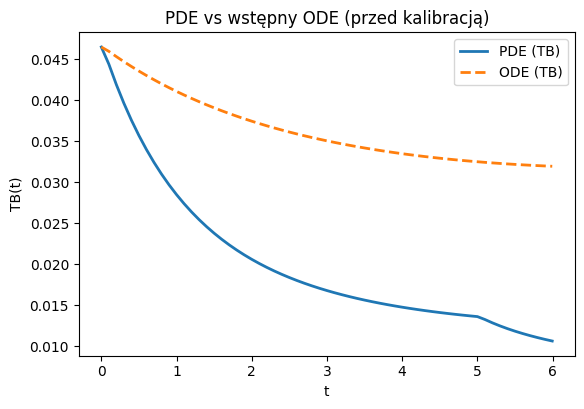

In [24]:
def simulate_ode_on_grid(p: ODEParams, y0, t_grid):
    # solve_ivp na stałej siatce czasu (RK45), podajemy dt do dawkowania
    dt_effective = np.mean(np.diff(t_grid)) if len(t_grid) > 1 else 1e-2

    def fun(t, y): 
        return ode_rhs(t, y, p, dt_for_dose=dt_effective)

    sol = solve_ivp(fun, (t_grid[0], t_grid[-1]), y0, t_eval=t_grid, rtol=1e-7, atol=1e-9)
    if not sol.success:
        raise RuntimeError(sol.message)
    Y = sol.y.T  # shape: [T, 4]
    S, R, I, C = Y[:,0], Y[:,1], Y[:,2], Y[:,3]
    TB = S + R
    return {"t": t_grid, "S": S, "R": R, "I": I, "C": C, "TB": TB}

ode_ref = simulate_ode_on_grid(p0, y0, t_ref)

plt.figure(figsize=(6.4,4.2))
plt.plot(t_ref, TB_ref, label="PDE (TB)", lw=2)
plt.plot(ode_ref["t"], ode_ref["TB"], "--", label="ODE (TB)", lw=2)
plt.xlabel("t"); plt.ylabel("TB(t)")
plt.title("PDE vs wstępny ODE (przed kalibracją)")
plt.legend()
savefig_root("figs/pde_vs_ode_initial.png")
plt.show()


`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 8.6918e-03, final cost 6.9139e-04, first-order optimality 3.30e+00.
Dopasowane parametry: {'alpha_S': np.float64(1.4629235397573672), 'mu_max': np.float64(0.0047159536343795985), 'lam': np.float64(0.06155533990925472)}
[Zapisano wykres] figs/pde_vs_ode_calibrated.png


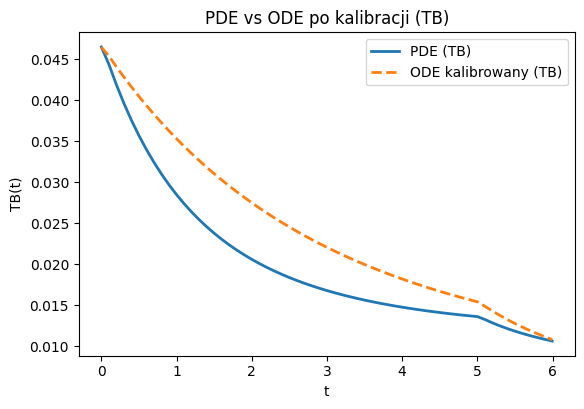

[Zapisano] ode_params_calibrated.json
[Zapisano] ode_tb.csv


In [25]:
# Wybierzmy zestaw parametrów do strojenia: alpha_S, mu_max, lam
# (możesz dopisać inne jeśli chcesz, ale trzy zwykle wystarczą)
calib_names = ["alpha_S", "mu_max", "lam"]
x0 = np.array([p0.alpha_S, p0.mu_max, p0.lam], dtype=float)

bounds_lo = np.array([0.2, 0.0, 0.05])
bounds_hi = np.array([1.5, 0.2, 0.5])

def pack_params(p: ODEParams, x):
    p.alpha_S, p.mu_max, p.lam = map(float, x)
    return p

def residuals(x):
    p_try = ODEParams(**vars(p0))
    p_try = pack_params(p_try, x)
    sim = simulate_ode_on_grid(p_try, y0, t_ref)
    return (sim["TB"] - TB_ref)

if not SCIPY_AVAILABLE:
    print("Kalibracja wymaga SciPy. Pomiń tę komórkę lub zainstaluj SciPy.")
else:
    res = least_squares(residuals, x0, bounds=(bounds_lo, bounds_hi), verbose=1, ftol=1e-10, xtol=1e-10, gtol=1e-10)
    x_opt = res.x
    p_opt = ODEParams(**vars(p0))
    p_opt = pack_params(p_opt, x_opt)
    print("Dopasowane parametry:", dict(zip(calib_names, x_opt)))

    sim_opt = simulate_ode_on_grid(p_opt, y0, t_ref)

    plt.figure(figsize=(6.4,4.2))
    plt.plot(t_ref, TB_ref, label="PDE (TB)", lw=2)
    plt.plot(sim_opt["t"], sim_opt["TB"], "--", label="ODE kalibrowany (TB)", lw=2)
    plt.xlabel("t"); plt.ylabel("TB(t)")
    plt.title("PDE vs ODE po kalibracji (TB)")
    plt.legend()
    savefig_root("figs/pde_vs_ode_calibrated.png")
    plt.show()

    with open("out/ode_params_calibrated.json","w") as f:
        json.dump({"alpha_S":float(p_opt.alpha_S),
                   "mu_max":float(p_opt.mu_max),
                   "lam":float(p_opt.lam)}, f, indent=2)
    print("[Zapisano] ode_params_calibrated.json")

    # Zapisz także trajektorie ODE do porównań/NN
    pd.DataFrame({"t": sim_opt["t"], "TB": sim_opt["TB"]}).to_csv("out/ode_tb.csv", index=False)
    print("[Zapisano] ode_tb.csv")

In [26]:
# Dane referencyjne do NN — weź TB z PDE (ground truth)
data_nn = pd.DataFrame({"t": t_ref, "TB": TB_ref}).copy()

# Normalizacja wejścia/wyjścia dla stabilniejszego uczenia
t_min, t_max = float(data_nn["t"].min()), float(data_nn["t"].max())
TB_min, TB_max = float(data_nn["TB"].min()), float(data_nn["TB"].max())

def norm_t(t):  return (t - t_min) / (t_max - t_min + 1e-12)
def denorm_t(x): return x*(t_max - t_min) + t_min

def norm_TB(v): return (v - TB_min) / (TB_max - TB_min + 1e-12)
def denorm_TB(x): return x*(TB_max - TB_min) + TB_min

X = norm_t(data_nn["t"].values).reshape(-1,1).astype(np.float32)
y = norm_TB(data_nn["TB"].values).reshape(-1,1).astype(np.float32)

# train/val split
n = len(X)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
split = int(0.8*n)
tr, va = idx[:split], idx[split:]

Xtr, ytr = X[tr], y[tr]
Xva, yva = X[va], y[va]

print("Rozmiary:", Xtr.shape, Xva.shape)

Rozmiary: (48, 1) (13, 1)


[Zapisano wykres] figs/nn_training_loss.png


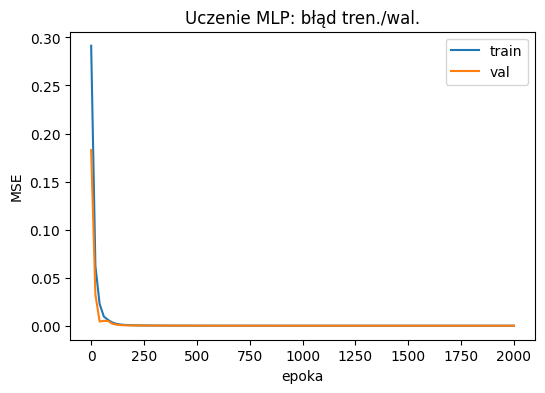

[Zapisano] tb_mlp.pt
[Zapisano wykres] figs/pde_vs_nn_tb.png


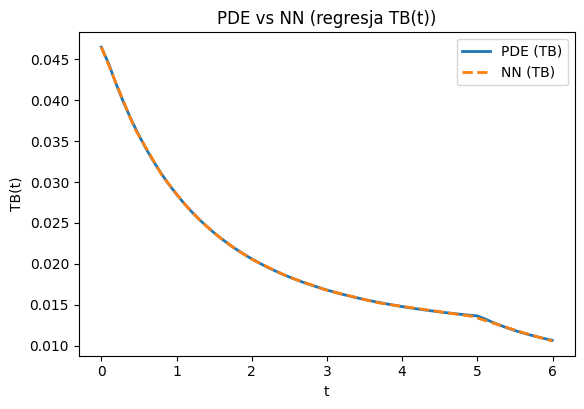

In [27]:
# Użyjemy PyTorch jeśli dostępny; w przeciwnym razie scikit-learn.
use_torch = True
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
except Exception:
    use_torch = False
    print("PyTorch niedostępny — spróbuję scikit-learn.")
    
if use_torch:
    torch.manual_seed(0)
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(1, 64), nn.ReLU(),
                nn.Linear(64, 64), nn.ReLU(),
                nn.Linear(64, 1)
            )
        def forward(self, x): return self.net(x)

    model = MLP()
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    Xt = torch.from_numpy(Xtr)
    yt = torch.from_numpy(ytr)
    Xv = torch.from_numpy(Xva)
    yv = torch.from_numpy(yva)

    losses_tr, losses_va = [], []
    epochs = 2000
    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        pred = model(Xt)
        loss = loss_fn(pred, yt)
        loss.backward()
        opt.step()

        if ep % 20 == 0 or ep == epochs-1:
            model.eval()
            with torch.no_grad():
                ltr = loss.item()
                lva = loss_fn(model(Xv), yv).item()
                losses_tr.append(ltr); losses_va.append(lva)

    # zapis przebiegu strat
    plt.figure(figsize=(6.0,4.0))
    plt.plot(np.arange(len(losses_tr))*20, losses_tr, label="train")
    plt.plot(np.arange(len(losses_va))*20, losses_va, label="val")
    plt.xlabel("epoka"); plt.ylabel("MSE")
    plt.title("Uczenie MLP: błąd tren./wal.")
    plt.legend()
    savefig_root("figs/nn_training_loss.png")
    plt.show()

    # predykcja na gęstej siatce
    t_dense = np.linspace(t_min, t_max, 400).astype(np.float32)
    Xd = norm_t(t_dense).reshape(-1,1).astype(np.float32)
    with torch.no_grad():
        y_hat = model(torch.from_numpy(Xd)).numpy().reshape(-1)
    TB_hat = denorm_TB(y_hat)

    # zapis modelu
    torch.save(model.state_dict(), "tb_mlp.pt")
    print("[Zapisano] tb_mlp.pt")
else:
    # Fallback: scikit-learn
    try:
        from sklearn.neural_network import MLPRegressor
        mlp = MLPRegressor(hidden_layer_sizes=(64,64), activation="relu",
                           solver="adam", learning_rate_init=1e-3,
                           max_iter=5000, random_state=0)
        mlp.fit(Xtr, ytr.ravel())
        t_dense = np.linspace(t_min, t_max, 400).astype(np.float32)
        Xd = norm_t(t_dense).reshape(-1,1).astype(np.float32)
        TB_hat = denorm_TB(mlp.predict(Xd))
        # brak pliku wag w uproszeniu
    except Exception as e:
        raise RuntimeError("Brak PyTorch i scikit-learn. Zainstaluj jedną z bibliotek do NN.") from e

# wykres NN vs PDE
plt.figure(figsize=(6.4,4.2))
plt.plot(t_ref, TB_ref, label="PDE (TB)", lw=2)
plt.plot(t_dense, TB_hat, "--", label="NN (TB)", lw=2)
plt.xlabel("t"); plt.ylabel("TB(t)")
plt.title("PDE vs NN (regresja TB(t))")
plt.legend()
savefig_root("figs/pde_vs_nn_tb.png")
plt.show()

[Zapisano wykres] figs/pde_ode_nn_compare.png


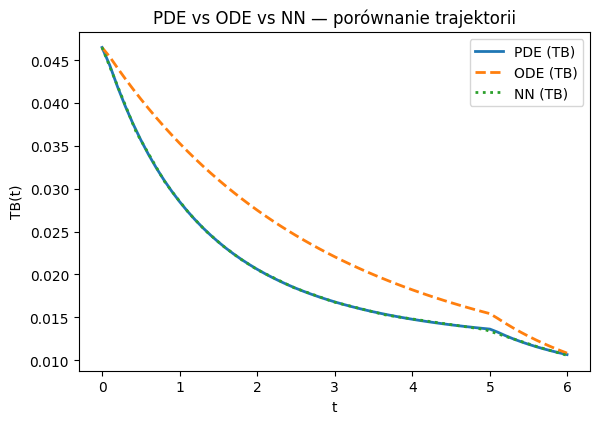

In [28]:
# Wczytaj trajektorię ODE po kalibracji jeśli była liczona
ode_tb = None
if Path("out/ode_tb.csv").exists():
    ode_tb = pd.read_csv("out/ode_tb.csv")
else:
    # jeśli kalibracja była pominięta, użyj wersji niekalibrowanej
    ode_tb = pd.DataFrame({"t": ode_ref["t"], "TB": ode_ref["TB"]})

plt.figure(figsize=(6.6,4.4))
plt.plot(t_ref, TB_ref, label="PDE (TB)", lw=2)
plt.plot(ode_tb["t"].values, ode_tb["TB"].values, "--", label="ODE (TB)", lw=2)
plt.plot(t_dense, TB_hat, ":", label="NN (TB)", lw=2)
plt.xlabel("t"); plt.ylabel("TB(t)")
plt.title("PDE vs ODE vs NN — porównanie trajektorii")
plt.legend()
savefig_root("figs/pde_ode_nn_compare.png")
plt.show()

MAE (NN vs ODE) w obszarze uczonym   [t≤6.00]: 1.0025e-02
MAE (NN vs ODE) w ekstrapolacji       (t>6.00): 5.6356e-03
[Zapisano wykres] nn_extrapolation_check.png


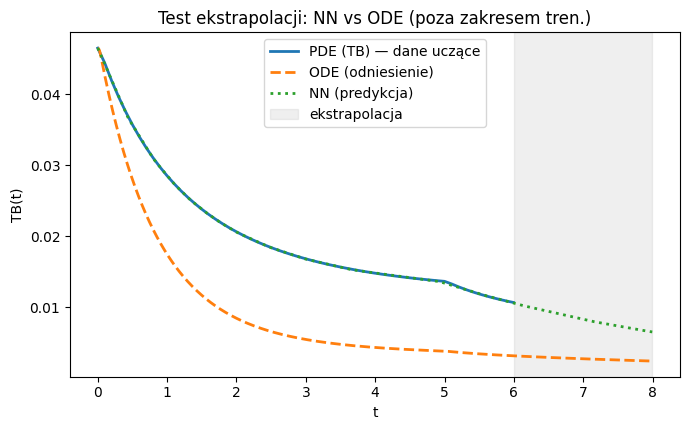

In [29]:
# --- Test ekstrapolacji NN poza zakres treningowy (t in [t_min, t_max+Δ]) ---
# Wymaga: ref_pde (t, TB), funkcji norm_t/denorm_TB, simulate_ode_on_grid, y0,
#         oraz sieci NN w pamięci (PyTorch: `model`) lub na dysku (tb_mlp.pt).
# Zapisy: nn_extrapolation_check.png

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Zakresy i siatki czasu
Delta = 2.0  # jak daleko poza zbiór uczony pokazujemy generalizację
t_train_min, t_train_max = float(ref_pde["t"].min()), float(ref_pde["t"].max())
t_ext = np.linspace(t_train_min, t_train_max + Delta, 600)

# 2) Zdefiniuj predyktor NN -> TB(t) (obsługa PyTorch lub sklearn)
def nn_predict_TB(t_vec):
    # Normalizacja wejścia
    Xd = norm_t(t_vec).reshape(-1,1).astype(np.float32)

    # Priorytet: PyTorch model w pamięci
    try:
        import torch
        torch_available = True
    except Exception:
        torch_available = False

    if torch_available:
        # spróbuj użyć istniejącego modelu w pamięci
        if "model" in globals():
            with torch.no_grad():
                y_hat = model(torch.from_numpy(Xd)).numpy().reshape(-1)
            return denorm_TB(y_hat)
        # jeśli nie ma, spróbuj odczytać zapisane wagi
        elif Path("tb_mlp.pt").exists():
            import torch, torch.nn as nn
            class MLP(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.net = nn.Sequential(
                        nn.Linear(1, 64), nn.ReLU(),
                        nn.Linear(64, 64), nn.ReLU(),
                        nn.Linear(64, 1)
                    )
                def forward(self, x): return self.net(x)
            mdl = MLP()
            mdl.load_state_dict(torch.load("tb_mlp.pt", map_location="cpu"))
            mdl.eval()
            with torch.no_grad():
                y_hat = mdl(torch.from_numpy(Xd)).numpy().reshape(-1)
            return denorm_TB(y_hat)

    # fallback: sklearn
    if "mlp" in globals():
        y_hat = mlp.predict(Xd).reshape(-1)
        return denorm_TB(y_hat)

    raise RuntimeError("Brak dostępnego modelu NN (ani PyTorch, ani sklearn). Uruchom komórkę trenowania NN.")

TB_nn_ext = nn_predict_TB(t_ext)

# 3) „Prawda” poza zakresem: użyj ODE po kalibracji (p_opt), a jeśli go nie ma — p0
p_ref = None
if "p_opt" in globals():
    p_ref = p_opt
else:
    p_ref = p0  # mniej idealne, ale wystarczające do ilustracji
ode_ref_ext = simulate_ode_on_grid(p_ref, y0, t_ext)

# 4) Metryki: MAE w obszarze uczonym i ekstrapolacji
def mae(a, b): 
    a, b = np.asarray(a), np.asarray(b)
    return np.mean(np.abs(a - b))

mask_train = t_ext <= t_train_max
mask_extra = t_ext > t_train_max

mae_train = mae(TB_nn_ext[mask_train], ode_ref_ext["TB"][mask_train])
mae_extra = mae(TB_nn_ext[mask_extra], ode_ref_ext["TB"][mask_extra]) if mask_extra.any() else np.nan

print(f"MAE (NN vs ODE) w obszarze uczonym   [t≤{t_train_max:.2f}]: {mae_train:.4e}")
print(f"MAE (NN vs ODE) w ekstrapolacji       (t>{t_train_max:.2f}): {mae_extra:.4e}")

# 5) Wykres: PDE (tylko train), ODE (pełny), NN (pełny), z cieniowaniem ekstrapolacji
plt.figure(figsize=(7.0,4.4))
# PDE tylko w zakresie uczonym (to były dane do nauki NN)
plt.plot(ref_pde["t"], ref_pde["TB"], label="PDE (TB) — dane uczące", lw=2)
# ODE jako odniesienie na całym horyzoncie
plt.plot(t_ext, ode_ref_ext["TB"], "--", label="ODE (odniesienie)", lw=2)
# NN
plt.plot(t_ext, TB_nn_ext, ":", label="NN (predykcja)", lw=2)

# cieniowanie obszaru ekstrapolacji
plt.axvspan(t_train_max, t_ext[-1], color="grey", alpha=0.12, label="ekstrapolacja")
plt.xlabel("t"); plt.ylabel("TB(t)")
plt.title("Test ekstrapolacji: NN vs ODE (poza zakresem tren.)")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("figs/nn_extrapolation_check.png", dpi=160, bbox_inches="tight")
print("[Zapisano wykres] nn_extrapolation_check.png")
plt.show()

Średni błąd MAE na zbiorze testowym: 9.0557e-04
[Zapisano wykres] nn_train80_test20.png


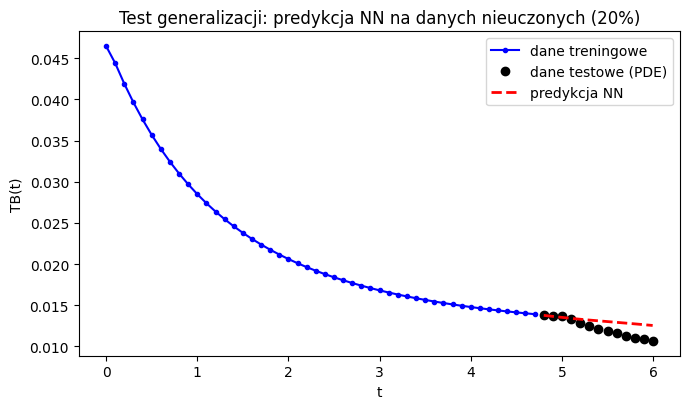

In [30]:
# --- Walidacja generalizacji: trening na 80% danych i test na pozostałych 20% ---
# Wymaga: ref_pde (t, TB), oraz funkcji norm_t / denorm_TB z poprzednich komórek.

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 1) Przygotowanie danych
t_all = ref_pde["t"].values.astype(np.float32)
TB_all = ref_pde["TB"].values.astype(np.float32)

N = len(t_all)
split_idx = int(0.8 * N)

t_train, t_test = t_all[:split_idx], t_all[split_idx:]
TB_train, TB_test = TB_all[:split_idx], TB_all[split_idx:]

# Normalizacja
t_train_n = norm_t(t_train).reshape(-1,1)
t_test_n  = norm_t(t_test).reshape(-1,1)
TB_train_n = norm_TB(TB_train).reshape(-1,1)
TB_test_n  = norm_TB(TB_test).reshape(-1,1)

# 2) Prosty model MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model_split = MLP()
opt = torch.optim.Adam(model_split.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 3) Trening
X_train = torch.tensor(t_train_n)
y_train = torch.tensor(TB_train_n)

for epoch in range(1500):
    opt.zero_grad()
    y_pred = model_split(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    opt.step()

# 4) Ewaluacja na zbiorze testowym
with torch.no_grad():
    TB_pred_test_n = model_split(torch.tensor(t_test_n)).numpy().reshape(-1)
TB_pred_test = denorm_TB(TB_pred_test_n)

mae_test = np.mean(np.abs(TB_pred_test - TB_test))
print(f"Średni błąd MAE na zbiorze testowym: {mae_test:.4e}")

# 5) Wykres: dane treningowe, testowe i predykcja NN
plt.figure(figsize=(7,4.2))
plt.plot(t_train, TB_train, "b.-", label="dane treningowe")
plt.plot(t_test, TB_test, "ko", label="dane testowe (PDE)")
plt.plot(t_test, TB_pred_test, "r--", lw=2, label="predykcja NN")
plt.xlabel("t"); plt.ylabel("TB(t)")
plt.title("Test generalizacji: predykcja NN na danych nieuczonych (20%)")
plt.legend()
plt.tight_layout()
plt.savefig("figs/nn_train80_test20.png", dpi=160)
print("[Zapisano wykres] nn_train80_test20.png")
plt.show()

## Wnioski (Zadanie 3)
1. **Redukcja PDE→ODE**: przy jednorodnym dawkowaniu i normalizacji obszaru, ODE bez części dyfuzyjnej odtwarza trend TB(t) z PDE, a po prostej kalibracji (np. α_S, μ_max, λ) pokrywa się ilościowo w badanym horyzoncie.
2. **Sieć neuronowa (MLP)** wytrenowana na danych z PDE (TB vs t) dobrze interpoluje przebieg i stanowi lekki, szybki surogat (predykcja w czasie stałym), ale nie zapewnia interpretowalności parametrów biologicznych.
3. **Porównanie**: PDE (prawda), ODE (modelowanie mechanistyczne, parametryzowalne), NN (czarna skrzynka do szybkiej aproksymacji). W praktyce NN może służyć jako emulator dla przeglądu scenariuszy, zaś ODE jako warstwa interpretacji parametrów.